In [0]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import re
import utils

In [2]:
from google.colab import drive
drive.mount('/content/mydrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/mydrive


In [0]:
songs = pd.read_csv('/content/mydrive/My Drive/data/drake-songs.csv')

In [4]:
text = ''
for index, row in songs['lyrics'].iteritems():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"[a-z']+", cleaned))
    
len(text)

367372

In [5]:
tokens = re.findall(r"[a-z'\s]", text)

chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(chars)

total chars: 28
[' ', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 122444


In [7]:
print('Vectorization...')

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [8]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

Build model...







In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
  

In [0]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [12]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





122444/122444 [==============================] - 86s 705us/step - loss: 1.8640
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "our lyrics do shit for me i told my stor"
our lyrics do shit for me i told my stor me the the the way the way the the me i don't gon' i got the way the the the the the the look the the with me i be like i so and i somethin' i don't got the the way the the way the the the the the but i don't look and i wanna so chong on me the they got a be like i don't gon' i love i be like i so i got the the they somethin' the the be look and i got i got i so and the wood the the the the the w
----- diversity: 0.5
----- Generating with seed: "our lyrics do shit for me i told my stor"
our lyrics do shit for me i told my story i don't look the mecher i say you look and i just to go she reas i blace you somethin' the real but in t

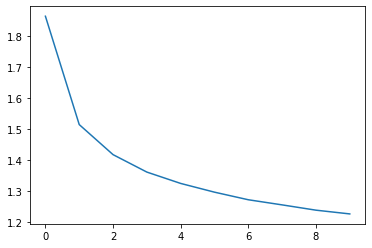

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

In [0]:
  def generate_output():
    generated = ''
    usr_input = input("Write the beginning of your poem, the Drake machine will complete it. Your input is: ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [19]:
Tx = 40
generate_output()

Write the beginning of your poem, the Drake machine will complete it. Your input is: How did I end here


Here is your poem: 

How did I end here i don't donet in the bout to take the bottom now it don't wanna be the backward to the back there the control that i don't want that this shit that i got the controuser betwer and i wanna be the bout to be the club any the way too but i can tell me the bout a new thank when i got me wanna be the chills i start that i don't want that i start to be the bout a good to the bout it and i don't wanna b